# Adaptive spline fit

In [1]:
from astropy.io import fits
from astropy.table import QTable
import astropy.units as u
from datetime import datetime
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import teareduce as tea

In [2]:
time_ini = datetime.now()

Download the required files

In [3]:
for fname in [
    'notebooks/adaptivespl/response_data_BD33d2642_G100.fits',
    'notebooks/adaptivespl/skycalc_transmission_R20000_400-800nm.txt'
]:
    tea.get_cookbook_file(fname)

File response_data_BD33d2642_G100.fits downloaded!
File skycalc_transmission_R20000_400-800nm.txt downloaded!


There are many situations in which it is useful to perform a smooth fit to a series of points, but a polynomial fit does not provide the necessary flexibility. In such cases, spline fitting is often used. To facilitate this task, **teareduce** provides a class, named `AdaptiveLSQUnivariateSpline` that allows performing this type of fit without having to predefine the locations of the *knots* (the points where the different polynomial segments join to create a continuous and smooth curve), requiring only the specification of the number of intermediate knots to use.

The `AdaptiveLSQUnivariateSpline` inherits from  `LSQUnivariateSpline` from the [scipy](https://docs.scipy.org/doc/scipy-1.16.2/reference/generated/scipy.interpolate.LSQUnivariateSpline.html) package, introducing two new parameters:
- `adaptive` (bool): if True, optimize the knot location numerically
- `tolerance` (float): value to be employed in the minimisation process

The numerical minimisation procedure is carried out with the help of the [lmfit](https://lmfit.github.io//lmfit-py/) package, following the procedure described in [Cardiel (2009)](https://articles.adsabs.harvard.edu/pdf/2009MNRAS.396..680C).

In [4]:
help(tea.AdaptiveLSQUnivariateSpline)

Help on class AdaptiveLSQUnivariateSpline in module teareduce.numsplines:

class AdaptiveLSQUnivariateSpline(scipy.interpolate._fitpack2.LSQUnivariateSpline)
 |  AdaptiveLSQUnivariateSpline(x, y, t, w=None, bbox=(None, None), k=3, ext=0, check_finite=False, adaptive=True, tolerance=1e-07)
 |
 |  Extend scipy.interpolate.LSQUnivariateSpline.
 |
 |  One-dimensional spline with explicit internal knots.
 |
 |  This is actually a wrapper of
 |  `scipy.interpolate.LSQUnivariateSpline`
 |  with the addition of using adaptive knot location determined
 |  numerically (after normalising the x and y arrays before
 |  the minimisation process).
 |
 |  Parameters
 |  ----------
 |  x : (N,) array_like
 |      Input dimension of data points -- must be increasing
 |  y : (N,) array_like
 |      Input dimension of data points
 |  t : (M,) array_like or int
 |      When integer it indicates the number of equidistant
 |      interior knots. When array_like it provides the location
 |      of the interio

## Example: computation of response curve

Read input data

In [5]:
input_file = 'response_data_BD33d2642_G100.fits'

with fits.open(input_file) as hdul:
    hdul.info()
    header = hdul[1].header

Filename: response_data_BD33d2642_G100.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     14   2048R x 2C   [D, D]   


The first FITS extension contains a binary table with the initial response curve obtained 

The first extension contains a binary table with the initial response curve, calculated as the ratio between the observed spectrum (in ${\rm ADU}/{\rm s}$) and the tabulated spectrum (in ${\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1}\,\unicode{x212B}^{-1}$).

In [6]:
header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                 2048 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'wavelength'                                                          
TFORM1  = 'D       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'response_data'                                                       
TFORM2  = 'D       '        

In [7]:
response_data = QTable.read(input_file, hdu=1)

We received a warning because the units `'ADU/s/FLAM'` in the second column of the table are not part of the FITS standard. To avoid problems in the code we will use next, we redefine this expression using valid units.

In [8]:
response_units = u.def_unit('ADU/s/FLAM')

In [9]:
response_data

wavelength,response_data
Angstrom,ADU/s/FLAM
float64,float64
4220.0,39427588791206.695
4222.0,39714436792249.06
4224.0,39784267391699.305
4226.0,40587338329114.48
4228.0,40123370683430.62
4230.0,42073303260572.02
4232.0,41331589582946.73
4234.0,41229670352075.2


We also read an ASCII file containing information on the transmission of the Earth's atmosphere.

In [10]:
telluric_tabulated = np.genfromtxt('skycalc_transmission_R20000_400-800nm.txt')
telluric_tabulated

array([[4.00007171e+02, 7.33015000e-01],
       [4.00027172e+02, 7.33056000e-01],
       [4.00047174e+02, 7.33099000e-01],
       ...,
       [8.99898946e+02, 9.74310000e-01],
       [8.99943942e+02, 9.73631000e-01],
       [8.99988940e+02, 9.73231000e-01]], shape=(16219, 2))

Prepare the data to be displayed

In [11]:
# response data
wavelength = response_data['wavelength']
response = response_data['response_data']

# transmission data
xtelluric = telluric_tabulated[:,0] * 10  # convert from nm to Angstrom
ytelluric = telluric_tabulated[:,1]
# extract data in the required wavelength range
iok = np.argwhere(np.logical_and(xtelluric >= wavelength.value.min(), xtelluric <= wavelength.value.max()))
xtelluric = xtelluric[iok]
ytelluric = ytelluric[iok]
# normalize data
ytelluric = ytelluric / ytelluric.max()

Define functions to plot data and legend (in this way we avoid repeating code)

In [12]:
def plot_data(ax1):
    ax1.plot(wavelength, response, label='response curve')
    ax1.set_xlabel(f'Wavelength ({wavelength.unit})')
    if str(response.unit) != 'ADU/s/FLAM':
        raise ValueError(f'unexpected response units: {str(response.unit)}')
    ax1.set_ylabel(r'Response (ADU/s) / (${\rm erg}\;{\rm cm}^{−2}\; {\rm s}^{−1}\;{\rm\AA}^{−1}$)')
    ax1.set_title(input_file)
    
    ax2 = ax1.twinx()
    ax2.plot(xtelluric, ytelluric, color='C2', label='telluric lines', alpha=0.5)
    ax2.set_ylabel('relative atmosphere transmission', color='C2')
    ax2.set_xlim(wavelength.value.min(), wavelength.value.max())

    return ax2

def display_legend(ax1, ax2):
    # merge labels
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    for handle, label in zip(handles2, labels2):
        handles1.append(handle)
        labels1.append(label)
    ax1.legend(handles1, labels1, loc=2)

Display the data

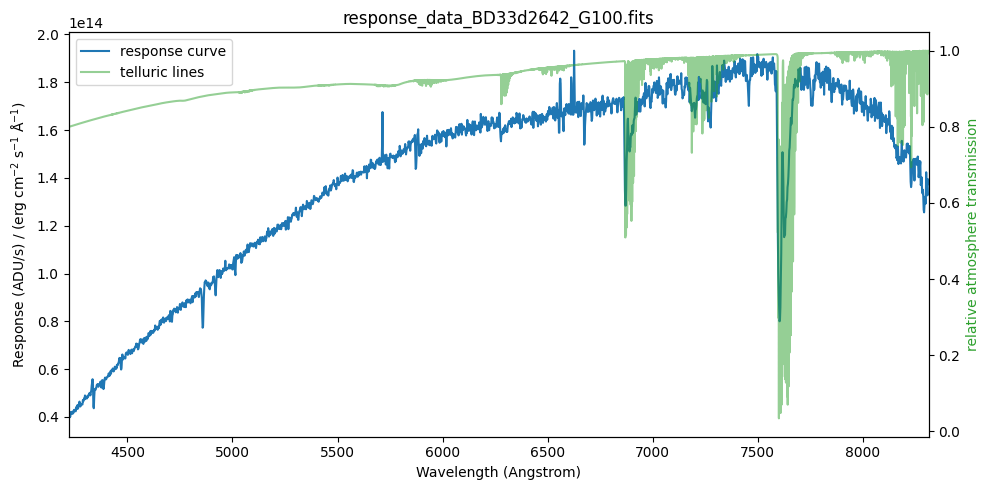

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = plot_data(ax1)
display_legend(ax1, ax2)

plt.tight_layout()
plt.show()

The previous graph shows the relative transmission of the atmosphere (green curve), which provides a very good explanation for the observed telluric lines. Note that we know the atmospheric transmission with very high spectral resolution, significantly higher than the spectral resolution of our observed spectrum. In principle, we would need to convolve the relative atmospheric transmission (for example, with a Gaussian kernel) in order to better reproduce the telluric absorptions. However, it is not worthwhile to spend time on this. Telluric absorptions also depend on the airmass, and correcting these regions of spectra is a formidable challenge; in this example we are simply going to ignore these regions of the spectra.

The response curve we will use will be a smooth fit to the resulting spectrum. But before performing the fit, we will remove problematic regions (particularly those affected by telluric absorptions). We define these regions as intervals in wavelength (Ångström).


In [14]:
# wavelength ranges
list_bad_regions = [
    (4200, 4250),
    (6260, 6350),
    (6450, 6600),
    (6850, 7050),
    (7160, 7400),
    (7520, 7770),
    (8100, 8270),
]

Auxiliary function to plot the problematic telluric windows.

In [15]:
def plot_telluric_windows(ax1):
    ymin, ymax = ax1.get_ylim()
    height = ymax - ymin
    for w1, w2 in list_bad_regions:
        width = w2 - w1
        rect = patches.Rectangle(xy=(w1, ymin), 
                                 width=width, height=height, 
                                 color='C1', alpha=0.2)
        ax1.add_patch(rect)

Repeat plot overplotting the telluric windows

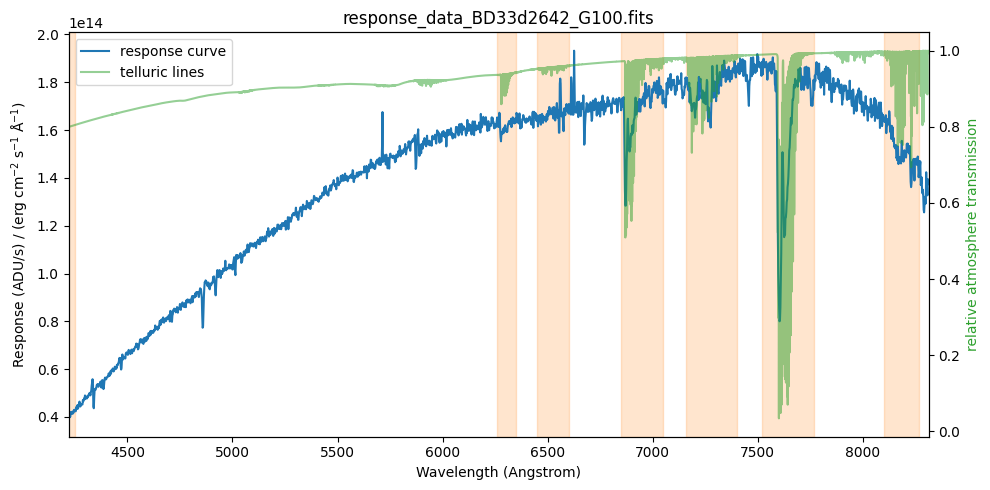

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = plot_data(ax1)
display_legend(ax1, ax2)
plot_telluric_windows(ax1)

plt.tight_layout()
plt.show()

We assign a very small weight to the spectral data points corresponding to the problematic regions (`weight_bad_region = 0.001`; the weight of a normal point will be `1.0`). Note that we keep these points nonetheless, so that the fit is computed over the entire spectral range.


In [17]:
naxis1 = len(wavelength)

weight = np.ones((naxis1))
weight_bad_region = 0.001

for w1, w2 in list_bad_regions:
    i1 = (np.abs(wavelength.value - w1)).argmin()
    i2 = (np.abs(wavelength.value - w2)).argmin()
    weight[i1:(i2+1)] = weight_bad_region

We perform a fit using an adaptive spline (spline fit with movable knots). By trial and error we find that 11 intermediate knots work well.

In [18]:
number_of_intermediate_knots = 11

spl = tea.AdaptiveLSQUnivariateSpline(x=wavelength.value, y=response.value, w=weight, 
                                      t=number_of_intermediate_knots)

Evaluate fit and determine location of knots.

In [19]:
response_curve = spl(wavelength.value) * response_units

xknots = spl.get_knots()
yknots = spl(xknots)

Display data and fit (with knots)

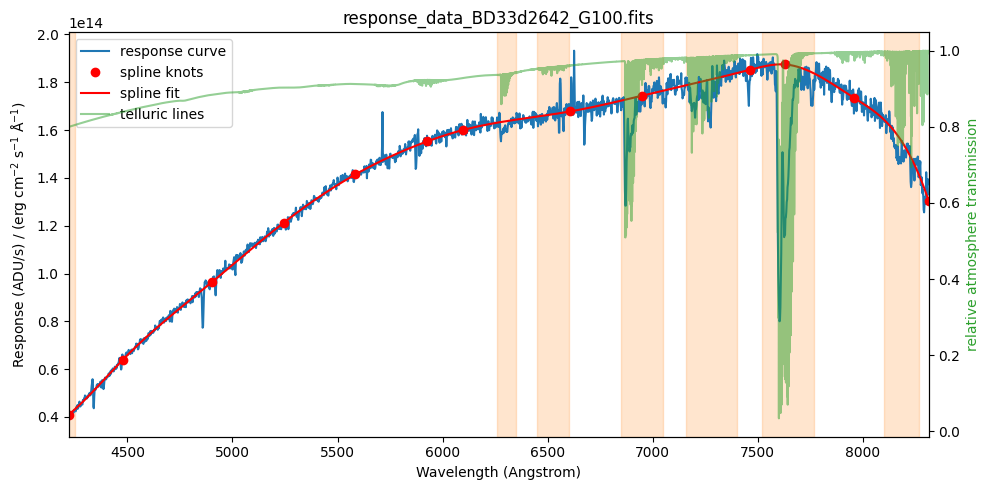

In [20]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = plot_data(ax1)
ax1.plot(xknots, yknots, 'ro', label='spline knots')
ax1.plot(wavelength, response_curve, 'r-', label='spline fit')
display_legend(ax1, ax2)
plot_telluric_windows(ax1)

plt.tight_layout()
plt.show()

In [21]:
tea.elapsed_time_since(time_ini)

system...........: Darwin
release..........: 24.6.0
machine..........: arm64
node.............: vpn-223-149.vpn.ucm.es
Python executable: /Users/cardiel/venv_tea/bin/python3.12
teareduce version: 0.4.9
Initial time.....: 2025-10-26 13:32:38.263831
Final time.......: 2025-10-26 13:32:39.703889
Elapsed time.....: 0:00:01.440058
